In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
%matplotlib inline

import ta
import catboost as ctb
import DeeperTradeLibrary as dpt
from sklearn.metrics import accuracy_score 
import datetime
import pickle


In [2]:
def squeeze(high, low, close, bb_length=None, bb_std=None, kc_length=None, kc_scalar=None, mom_length=None, mom_smooth=None, use_tr=None, offset=None, **kwargs):
    """Indicator: Squeeze Momentum (SQZ)"""
    # Validate arguments
    high = verify_series(high)
    low = verify_series(low)
    close = verify_series(close)
    offset = get_offset(offset)

    bb_length = int(bb_length) if bb_length and bb_length > 0 else 20
    bb_std = float(bb_std) if bb_std and bb_std > 0 else 2.
    kc_length = int(kc_length) if kc_length and kc_length > 0 else 20
    kc_scalar = float(kc_scalar) if kc_scalar and kc_scalar > 0 else 1.5
    mom_length = int(mom_length) if mom_length and mom_length > 0 else 12
    mom_smooth = int(mom_smooth) if mom_smooth and mom_smooth > 0 else 6

    use_tr = kwargs.setdefault("tr", True)
    asint = kwargs.pop("asint", True)
    mamode = kwargs.pop("mamode", "sma").lower()
    lazybear = kwargs.pop("lazybear", False)
    detailed = kwargs.pop("detailed", False)

    def simplify_columns(df, n=3):
        df.columns = df.columns.str.lower()
        return [c.split('_')[0][n-1:n] for c in df.columns]

    # Calculate Result
    bbd = bbands(close, length=bb_length, std=bb_std, mamode=mamode)
    kch = kc(high, low, close, length=kc_length, scalar=kc_scalar, mamode=mamode, tr=use_tr)

    # Simplify KC and BBAND column names for dynamic access
    bbd.columns = simplify_columns(bbd)
    kch.columns = simplify_columns(kch)

    if lazybear:
        highest_high = high.rolling(kc_length).max()
        lowest_low   = low.rolling(kc_length).min()
        avg_  = 0.25 * (highest_high + lowest_low) + 0.5 * kch.b

        squeeze = linreg(close - avg_, length=kc_length)

    else:
        momo = mom(close, length=mom_length)
        if mamode == "ema":
            squeeze = ema(momo, length=mom_smooth)
        else:
            squeeze = sma(momo, length=mom_smooth)

    # Classify Squeezes
    squeeze_on = (bbd.l > kch.l) & (bbd.u < kch.u)
    squeeze_off = (bbd.l < kch.l) & (bbd.u > kch.u)
    no_squeeze = ~squeeze_on & ~squeeze_off

    # Offset
    if offset != 0:
        squeeze = squeeze.shift(offset)
        squeeze_on = squeeze_on.shift(offset)
        squeeze_off = squeeze_off.shift(offset)
        no_squeeze = no_squeeze.shift(offset)

    # Handle fills
    if "fillna" in kwargs:
        squeeze.fillna(kwargs["fillna"], inplace=True)
        squeeze_on.fillna(kwargs["fillna"], inplace=True)
        squeeze_off.fillna(kwargs["fillna"], inplace=True)
        no_squeeze.fillna(kwargs["fillna"], inplace=True)
    if "fill_method" in kwargs:
        squeeze.fillna(method=kwargs["fill_method"], inplace=True)
        squeeze_on.fillna(method=kwargs["fill_method"], inplace=True)
        squeeze_off.fillna(method=kwargs["fill_method"], inplace=True)
        no_squeeze.fillna(method=kwargs["fill_method"], inplace=True)

    # Name and Categorize it
    _props = "" if use_tr else "hlr"
    _props += f"_{bb_length}_{bb_std}_{kc_length}_{kc_scalar}"
    _props += "_LB" if lazybear else ""
    squeeze.name = f"SQZ{_props}"

    data = {
        squeeze.name: squeeze,
        f"SQZ_ON": squeeze_on.astype(int) if asint else squeeze_on,
        f"SQZ_OFF": squeeze_off.astype(int) if asint else squeeze_off,
        f"SQZ_NO": no_squeeze.astype(int) if asint else no_squeeze
    }
    df = DataFrame(data)
    df.name = squeeze.name
    df.category = squeeze.category = "momentum"

    # Detailed Squeeze Series
    if detailed:
        pos_squeeze = squeeze[squeeze >= 0]
        neg_squeeze = squeeze[squeeze < 0]

        pos_inc, pos_dec = unsigned_differences(pos_squeeze, asint=True)
        neg_inc, neg_dec = unsigned_differences(neg_squeeze, asint=True)

        pos_inc *= squeeze
        pos_dec *= squeeze
        neg_dec *= squeeze
        neg_inc *= squeeze

        pos_inc.replace(0, npNaN, inplace=True)
        pos_dec.replace(0, npNaN, inplace=True)
        neg_dec.replace(0, npNaN, inplace=True)
        neg_inc.replace(0, npNaN, inplace=True)

        sqz_inc = squeeze * increasing(squeeze)
        sqz_dec = squeeze * decreasing(squeeze)
        sqz_inc.replace(0, npNaN, inplace=True)
        sqz_dec.replace(0, npNaN, inplace=True)

        # Handle fills
        if "fillna" in kwargs:
            sqz_inc.fillna(kwargs["fillna"], inplace=True)
            sqz_dec.fillna(kwargs["fillna"], inplace=True)
            pos_inc.fillna(kwargs["fillna"], inplace=True)
            pos_dec.fillna(kwargs["fillna"], inplace=True)
            neg_dec.fillna(kwargs["fillna"], inplace=True)
            neg_inc.fillna(kwargs["fillna"], inplace=True)
        if "fill_method" in kwargs:
            sqz_inc.fillna(method=kwargs["fill_method"], inplace=True)
            sqz_dec.fillna(method=kwargs["fill_method"], inplace=True)
            pos_inc.fillna(method=kwargs["fill_method"], inplace=True)
            pos_dec.fillna(method=kwargs["fill_method"], inplace=True)
            neg_dec.fillna(method=kwargs["fill_method"], inplace=True)
            neg_inc.fillna(method=kwargs["fill_method"], inplace=True)

        df[f"SQZ_INC"] = sqz_inc
        df[f"SQZ_DEC"] = sqz_dec
        df[f"SQZ_PINC"] = pos_inc
        df[f"SQZ_PDEC"] = pos_dec
        df[f"SQZ_NDEC"] = neg_dec
        df[f"SQZ_NINC"] = neg_inc

    return df

In [3]:
def feature_generator(df_process):
   
    df = df_process.copy()
   
    df['rsi14'] = ta.momentum.rsi(df.close, n=14)
 
    df['rsi14-t1'] = df['rsi14'].shift(1)  
 
    df['open-close'] = df.open - df.close
    df['open-close-t1'] = df['open-close'].shift(1)
    df['high-low'] = df.high - df.low
    df['high-low-t1'] = df['high-low'].shift(1)
    df['rol9'] = df.close.rolling(5).mean()
  
    df['label'] = (df.close.rolling(5, center=True).mean().diff() >= 0).astype(int)
 
    return df

In [4]:
#นำเข้าข้อมูล
df_master = pd.read_csv('GOLD_H4.csv')
#เปลี่ยนช่อง time ให้อยู่ในรูปแบบ datetime
df_master['time'] = pd.to_datetime(df_master['time'])
#Drop ช่อง Volume ทิ้ง เพราะตัวอย่างนี้ไม่ได้ใช้ในการทำ Feature
df_master.drop('volume', axis=1, inplace=True)
df_master

,time,open,high,low,close
0,2006-03-19 20:00:00,554.000,554.050,553.950,554.050
1,2006-03-20 00:00:00,554.050,556.050,553.650,555.750
2,2006-03-20 04:00:00,555.750,556.400,555.150,556.150
3,2006-03-20 08:00:00,556.150,556.250,553.750,553.750
4,2006-03-20 12:00:00,553.650,556.450,550.050,554.450
...,...,...,...,...,...
22781,2020-01-31 04:00:00,1572.295,1576.761,1571.692,1576.476
22782,2020-01-31 08:00:00,1576.526,1582.131,1576.203,1580.662
22783,2020-01-31 12:00:00,1580.703,1589.127,1578.401,1588.277
22784,2020-01-31 16:00:00,1588.221,1588.705,1581.024,1586.896


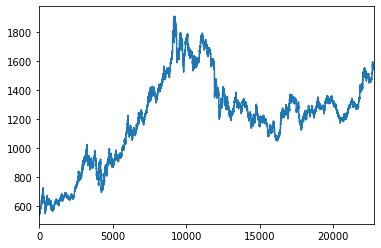

In [5]:
df_master['close'].plot()

In [6]:
df = feature_generator(df_master)
df

,time,open,high,low,close,rsi14,rsi14-t1,open-close,open-close-t1,high-low,high-low-t1,rol9,label
0,2006-03-19 20:00:00,554.000,554.050,553.950,554.050,100.000000,NaN,-0.050,NaN,0.100,NaN,NaN,0
1,2006-03-20 00:00:00,554.050,556.050,553.650,555.750,100.000000,100.000000,-1.700,-0.050,2.400,0.100,NaN,0
2,2006-03-20 04:00:00,555.750,556.400,555.150,556.150,100.000000,100.000000,-0.400,-1.700,1.250,2.400,NaN,0
3,2006-03-20 08:00:00,556.150,556.250,553.750,553.750,43.359422,100.000000,2.400,-0.400,2.500,1.250,NaN,0
4,2006-03-20 12:00:00,553.650,556.450,550.050,554.450,51.914321,43.359422,-0.800,2.400,6.400,2.500,554.8300,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22781,2020-01-31 04:00:00,1572.295,1576.761,1571.692,1576.476,52.633031,47.566437,-4.181,2.903,5.069,4.584,1577.5190,1
22782,2020-01-31 08:00:00,1576.526,1582.131,1576.203,1580.662,57.063031,52.633031,-4.136,-4.181,5.928,5.069,1576.9010,1
22783,2020-01-31 12:00:00,1580.703,1589.127,1578.401,1588.277,63.711900,57.063031,-7.574,-4.136,10.726,5.928,1578.5736,1
22784,2020-01-31 16:00:00,1588.221,1588.705,1581.024,1586.896,61.841624,63.711900,1.325,-7.574,7.681,10.726,1580.9130,0
